In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima  

import os

In [ ]:
data=pd.read_csv("wheatherdata.csv")
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


<center><b>Exploratory Data Analysis</b></center>

* First, how many rows and columns, we have in our dataset

In [ ]:
data.shape


(100990, 20)

**Data types and columns name**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
datetime_utc    100990 non-null object
 _conds         100918 non-null object
 _dewptm        100369 non-null float64
 _fog           100990 non-null int64
 _hail          100990 non-null int64
 _heatindexm    29155 non-null float64
 _hum           100233 non-null float64
 _precipm       0 non-null float64
 _pressurem     100758 non-null float64
 _rain          100990 non-null int64
 _snow          100990 non-null int64
 _tempm         100317 non-null float64
 _thunder       100990 non-null int64
 _tornado       100990 non-null int64
 _vism          96562 non-null float64
 _wdird         86235 non-null float64
 _wdire         86235 non-null object
 _wgustm        1072 non-null float64
 _windchillm    579 non-null float64
 _wspdm         98632 non-null float64
dtypes: float64(11), int64(6), object(3)
memory usage: 15.4+ MB


**Counting null values in our dataset. There will 100990 in our dataset**

In [ ]:
null=data[data.isnull().any(axis=1)]
print("Null values:",null.shape[0])

Null values: 100990


**_conds is a categorical data variable in our dataset.first, check how many categories of wheater are in Dehli**   

In [ ]:
data[' _conds'].value_counts()

Haze                             47602
Smoke                            20760
Mist                              9375
Clear                             3129
Widespread Dust                   2856
Fog                               2760
Scattered Clouds                  2209
Partly Cloudy                     2091
Shallow Fog                       1860
Mostly Cloudy                     1537
Light Rain                        1302
Partial Fog                       1031
Patches of Fog                     901
Thunderstorms and Rain             486
Heavy Fog                          421
Light Drizzle                      414
Rain                               394
Unknown                            383
Blowing Sand                       378
Overcast                           326
Thunderstorm                       192
Light Thunderstorms and Rain       176
Drizzle                            112
Light Thunderstorm                  64
Light Fog                           64
Heavy Rain               

**The data shows Haza and Smoke are the most frequent values in our dataset.The Bar Graph has given the clear pictuer**

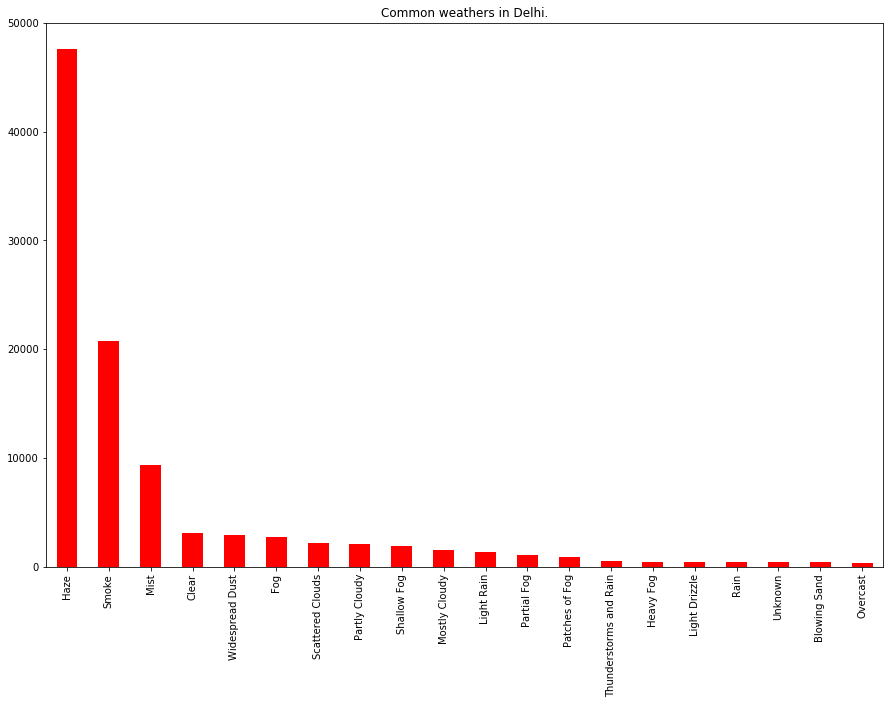

In [ ]:
plt.figure(figsize=(15,10))
data[' _conds'].value_counts().head(20).plot(kind='bar', color='red')
plt.title('Common weathers in Delhi.')
plt.show()

**Consider Date and Temperatuer featuer from our dataset**

In [ ]:
data=data[["datetime_utc"," _tempm"]]
data.columns=['date', 'temperatuer']
data.head()

,date,temperatuer
0,19961101-11:00,30.0
1,19961101-12:00,28.0
2,19961101-13:00,24.0
3,19961101-14:00,24.0
4,19961101-16:00,23.0


**Convert data featuer into pandas DateTime object**

In [ ]:
data["date"]=pd.to_datetime(data["date"],format="%Y%m%d-%H:%M")
data.dtypes

date           datetime64[ns]
temperatuer           float64
dtype: object

## Pandas Datetime Index

We'll usually deal with time series as a datetime index when working with pandas dataframes. Fortunately pandas has a lot of functions and methods to work with time series!<br>
For more on the pandas DatetimeIndex visit https://pandas.pydata.org/pandas-docs/stable/timeseries.html
**We can easily apply other operation like mean, median and mode. Thus, we set datecolumn as index of the dataframe with dealing with timeseries data. Also we can extrat data by yearly, monthly, weekly and hourly bases**

In [ ]:
data=data.set_index("date")


In [ ]:
data.tail()

,temperatuer
date,
2017-04-24 06:00:00,34.0
2017-04-24 09:00:00,38.0
2017-04-24 12:00:00,36.0
2017-04-24 15:00:00,32.0
2017-04-24 18:00:00,30.0


**Extract average temperatuer by yearly, monthly, weekly and hourly bases**

In [ ]:
daily_mean   = data.groupby(data.index.day).mean()
monthly_mean = data.groupby(data.index.month).mean()
hourly_mean  = data.groupby(data.index.hour).mean()
yearly_mean  = data.groupby(data.index.year).mean()

In [ ]:
daily_mean


,temperatuer
date,
1,25.197923
2,25.160305
3,25.310025
4,25.474379
5,25.442783
6,25.367197
7,25.503726
8,25.424398
9,25.425346


**The Graph clear shows that the temperature increases at afternoon**

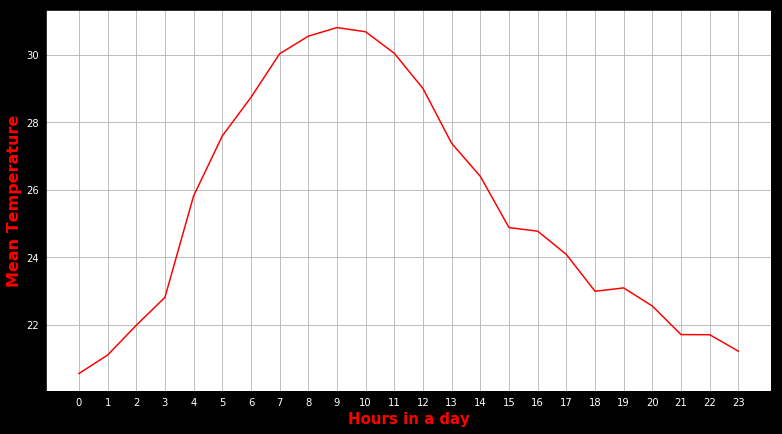

In [ ]:
fig=plt.figure(figsize=(13,7),facecolor="black")
ax=plt.axes()
ax.set_facecolor("white")
plt.plot(hourly_mean, color='red')
plt.grid(True)
plt.yticks(color='white')
plt.xticks(range(0,24), color='white')
plt.xlabel("Hours in a day",fontsize=15,fontweight="bold", color='red')
plt.ylabel("Mean Temperature",fontsize=16,fontweight="bold", color='red')
plt.show()


****The Graph clear shows that the temperature is high from May to July****

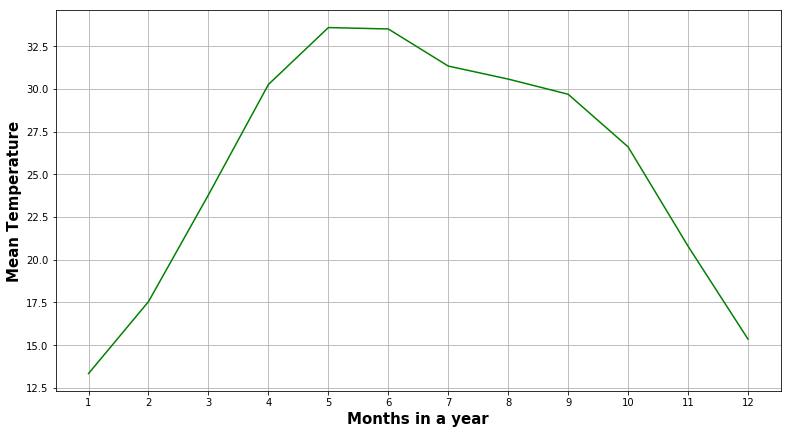

In [ ]:
fig=plt.figure(figsize=(13,7),facecolor="white")
ax=plt.axes()
ax.set_facecolor("white")
plt.plot(monthly_mean, color='green')
plt.grid(True)
plt.xticks(range(1,13))
plt.xlabel("Months in a year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.show()

**sharp increase in average yearly temperature in late 1990s and have stabalized after 2002**

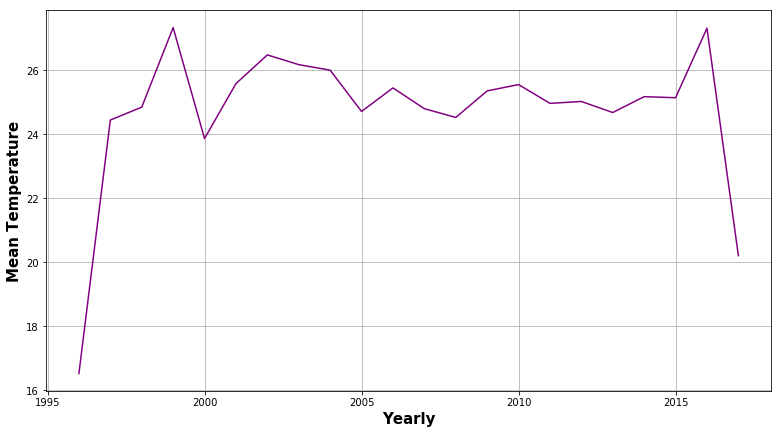

In [ ]:
fig=plt.figure(figsize=(13,7),facecolor="white")
ax=plt.axes()
ax.set_facecolor("white")
plt.plot(yearly_mean, color='purple')
plt.grid(True)
plt.xlabel("Yearly",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.show()

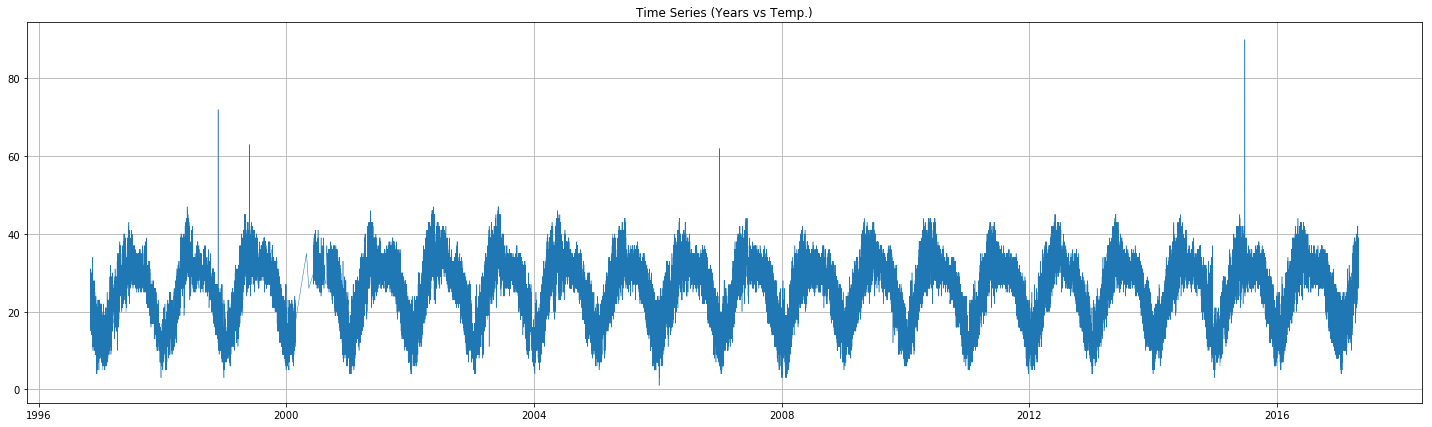

In [ ]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

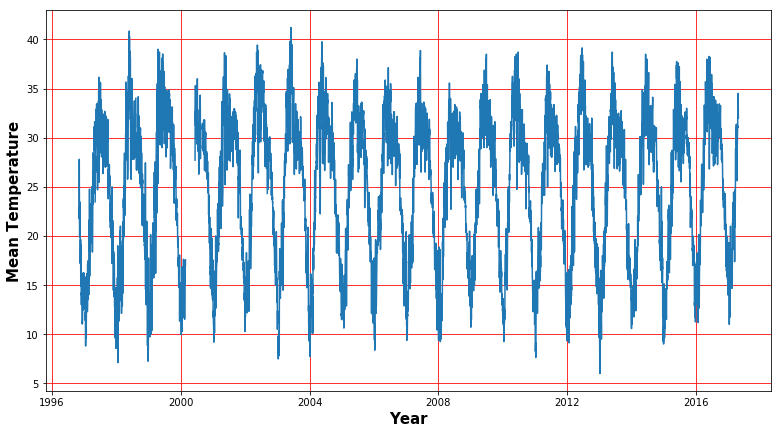

In [ ]:
daily=data.resample("D").mean()
fig=plt.figure(figsize=(13,7),facecolor="white")
ax=plt.axes()
ax.set_facecolor("white")
plt.xlabel("Year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True, color='red')
plt.plot(daily)
plt.show()

**Filling Missing Data**

In [ ]:
print("Null values before:",daily.isnull().sum())

daily=daily.fillna(method="ffill")

print("Null values After:",daily.isnull().sum())

Null values before: temperatuer    0
dtype: int64
Null values After: temperatuer    0
dtype: int64


**MA(Moving Average to predict daily temperature)**

In [ ]:
actual=daily["temperatuer"].to_frame().rename(columns={"temperatuer":"actual"})
predicted=daily["temperatuer"].to_frame().shift(1).rename(columns={"temperatuer":"predicted"})

df_daily=pd.concat([actual,predicted],axis=1)
df_daily.head()
df_daily=df_daily[1:]
df.head()

,temperatuer
date,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


**The blue line shows actual data and orange as predicted temperature, we can see that the plot is so identical and the forecasting is so precise**

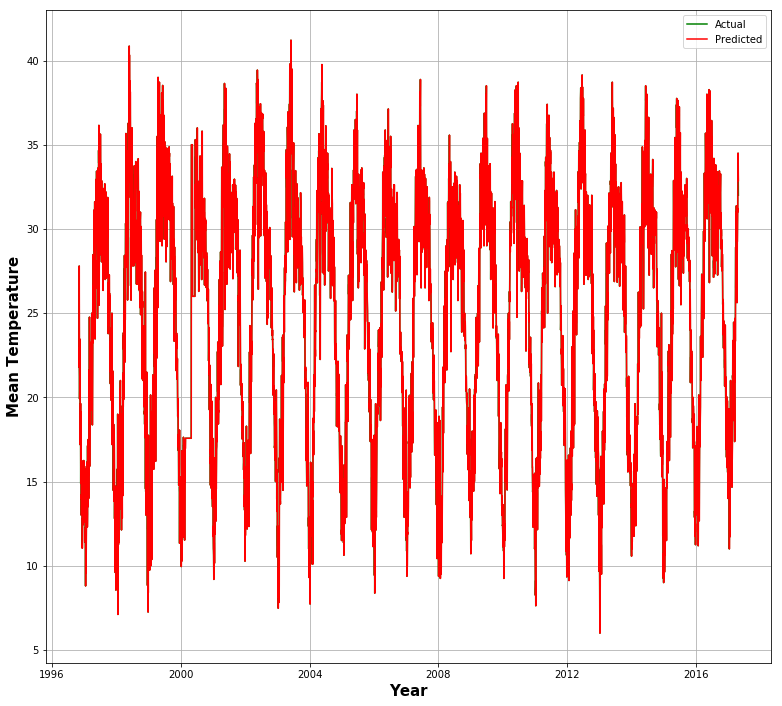

In [ ]:
fig=plt.figure(figsize=(13,12),facecolor="white")
ax=plt.axes()
ax.set_facecolor("white")
plt.plot(df_daily["actual"],label="Actual", color='green')
plt.plot(df_daily["predicted"],label="Predicted", color='red')
plt.xlabel("Year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.legend(loc="best")
plt.show()

**Disadvantage of MA**
* Since I am just taking the temperature of past as the temperature of future, in a long run my model will just be predicting same recorded temperatures, this is so Naive of MA model.
* We know that for past decades we are experiencing a rise in temperature(global warming), and it will increase in the future, so for that reason we also have to take into account of exogenous features/variables, which MA neglects.

**RMSE values accounts to 3.6 which is pretty good.**



In [ ]:
rmse=mean_squared_error(df_daily["actual"],df_daily["predicted"])
print("RMSE: {:.1f}".format(rmse))

RMSE: 3.0


## Forecasting with LSTM Method
For this example we'll use the same Wheater dataset, and we'll split the data into 100940 training records and 50 testing records. Then we'll evaluate the performance of the model.

In [ ]:
data=pd.read_csv("wheatherdata.csv")
data=data[["datetime_utc"," _tempm"]]
data.columns=['date', 'temperatuer']
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace= True)
data =data.resample('D').mean()
data = data[['temperatuer' ]]
data['temperatuer'] = data['temperatuer'].interpolate()# we will fill the null row



## Train Test Split

In [ ]:
data=data.values
data = data.astype('float32')
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 7300
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:] 

## Evaluating Model against Test Set

In [ ]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2021-10-20 20:14:23.590281: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 20:14:23.626727: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2594085000 Hz
2021-10-20 20:14:23.626985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5645e00306f0 executing computations on platform Host. Devices:
2021-10-20 20:14:23.627009: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2021-10-20 20:14:23.628152: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
7300/7300 [==============================] - 54s 7ms/step - loss: 0.0422
Epoch 2/50
7300/7300 [==============================] - 76s 10ms/step - loss: 0.0170
Epoch 3/50
7300/7300 [==============================] - 72s 10ms/step - loss: 0.0143
Epoch 4/50
7300/7300 [==============================] - 77s 11ms/step - loss: 0.0122
Epoch 5/50
7300/7300 [==============================] - 63s 9ms/step - loss: 0.0099
Epoch 6/50
7300/7300 [==============================] - 66s 9ms/step - loss: 0.0094
Epoch 7/50
7300/7300 [==============================] - 68s 9ms/step - loss: 0.0095
Epoch 8/50
7300/7300 [==============================] - 67s 9ms/step - loss: 0.0093
Epoch 9/50
7300/7300 [==============================] - 79s 11ms/step - loss: 0.0093
Epoch 10/50
7300/7300 [==============================] - 65s 9ms/step - loss: 0.0090
Epoch 11/50
7300/7300 [==============================] - 83s 11ms/step - loss: 0.0094
Epoch 12/50
7300/7300 [==============================] - 92s 13ms/ste

Text(0.5, 1.0, 'Model Accuracy')

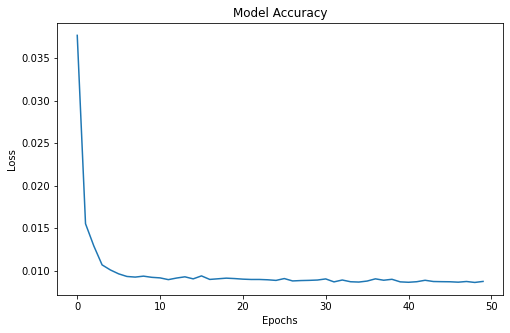

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [ ]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)


NameError: name 'Xtest' is not defined

**We obtain a rmse of 3.69 which is higher that of SARIMAX model, however Neural Networks always provides room for model improvement,thus by using valid activation function and neurons this can be improved**

In [ ]:
mean_squared_error(Ytest,preds)


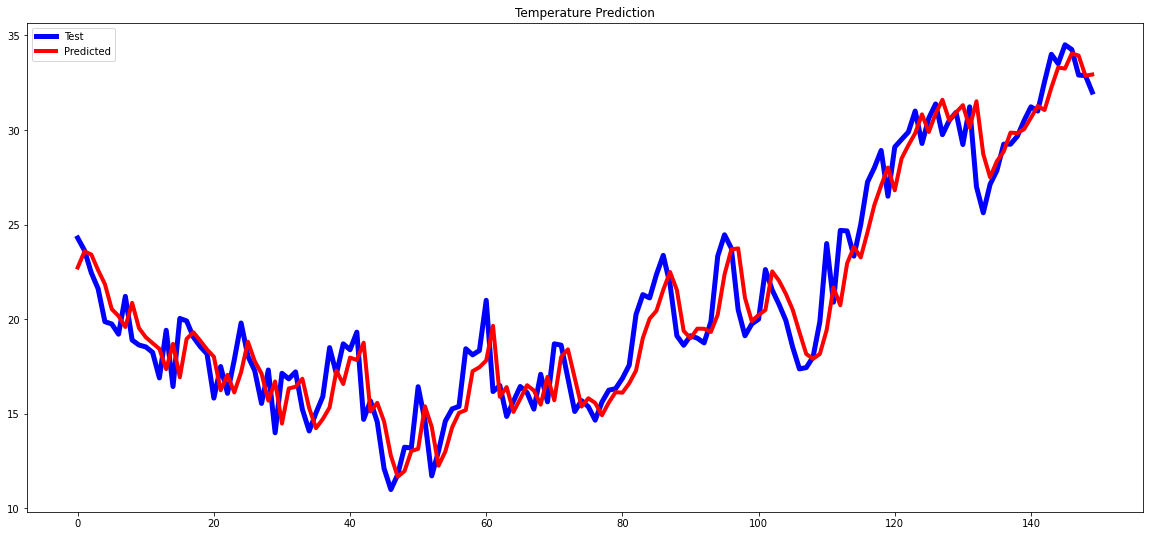

In [ ]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [ ]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])
results = pd.concat([test,pred],axis=1)
results

,Actual,Predict
0,24.294117,22.730104
1,23.636364,23.581955
2,22.454546,23.421017
3,21.611111,22.594574
4,19.869566,21.854445
...,...,...
145,34.500000,33.242031
146,34.250000,34.042778
147,32.900002,33.932484
148,32.875000,32.867321


**SARIMA**

In [ ]:
data=pd.read_csv("wheatherdata.csv")
data=data[["datetime_utc"," _tempm"]]
data.columns=['date', 'temperatuer']
data['temperatuer'].fillna(data['temperatuer'].mode()[0], inplace=True)
data['date'] = pd.to_datetime(data['date']).dt.date
data.set_index('date', inplace= True)
data.index.freq = 'MS'



In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(data['temperatuer'],seasonal=True,m=12).summary()

/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[

In [ ]:
# Set one year for testing
train = data.iloc[:100940]
test = data.iloc[100940:]

In [ ]:
model = SARIMAX(train['temperatuer'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
#results.summary()

/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40746D+00    |proj g|=  1.44254D-01

At iterate    5    f=  2.36390D+00    |proj g|=  1.51737D-02

At iterate   10    f=  2.35639D+00    |proj g|=  5.44329D-03

At iterate   15    f=  2.35626D+00    |proj g|=  5.62384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   4.374D-05   2.356D+00
  F =   2.3562634101383750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')
df_predictions=predictions.to_frame()
df_predictions.index = test.index
test['predicated_temperatuer'] = df_predictions['SARIMA(0,1,3)(1,0,1,12) Predictions']
test

/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/adnan/anaconda3/envs/tsa_course_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Evaluate the Model

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['temperatuer'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 29.88558369


In [ ]:

from statsmodels.tools.eval_measures import rmse

error = rmse(test['temperatuer'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 5.466770865


100940

100989